<H1>Changing price of other assets</H1>
This time, we change the price of the rest of the pool, comprising 80% of TVL, while leaving stablecoin and TKN unchanged. As before, the different colors represent the IL resulting from different initial weights of TKN. We can see that during a bull market (which doesn't include TKN) impermanent loss is worse, because the share of TKN in the pool decreases. 

In [19]:
import sys
import os
import glob
import random
sys.path.append('../../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.05},
    'USD': {'usd price': 1, 'weight': 0.15},
    'TKN': {'usd price': 1, 'weight': 0.0001},
    'TKN2': {'usd price': 1,  'weight': 0.7999}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0,
            lrna_fee=0,
            withdrawal_fee=False
        )
    },
    agents = {
        'LP': Agent(
            holdings={'TKN': 10000},
            trade_strategy=invest_all('omnipool')
        ),
        'Arbitrageur': Agent(
            holdings={tkn: 10000000 for tkn in assets},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                # arb_precision=20
            )
        ),
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)

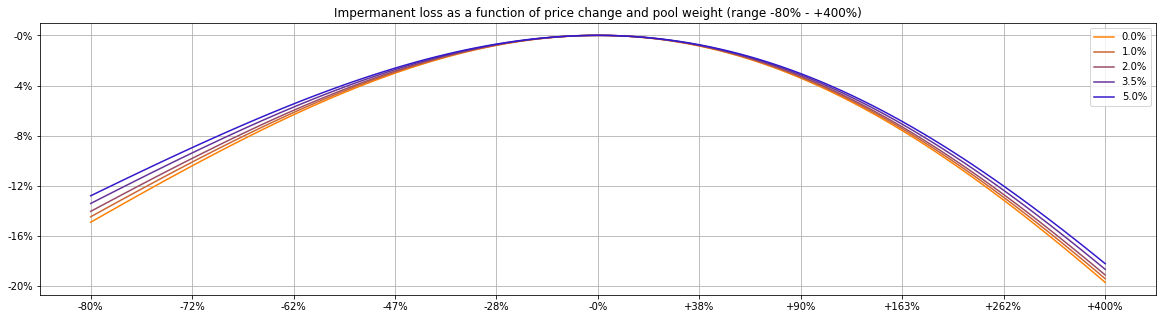

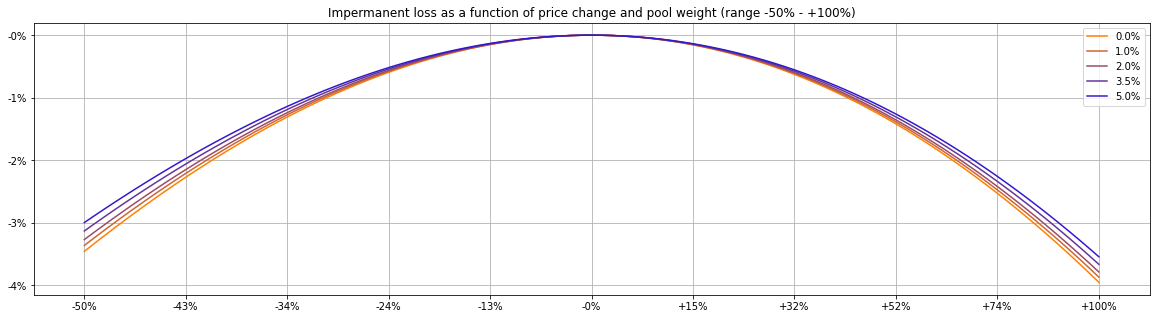

In [20]:
steps = 101
# price_min = 0.2
# price_max = 5
for price_min, price_max in [(0.2, 5), (0.5, 2)]:
    step_factor = (price_max / price_min) ** (1 / (steps - 1))
    price_move_range = [price_min * step_factor ** i for i in range(steps)]
    events = []
    weight_factors = [0.0001, 0.01, 0.02, 0.035, 0.05]


    for w, weight in enumerate(weight_factors):
        assets = {
            'HDX': {'usd price': 0.05, 'weight': 0.05},
            'USD': {'usd price': 1, 'weight': 0.15},
            'TKN': {'usd price': 1, 'weight': weight},
            'TKN2': {'usd price': 1, 'weight': 0.8 - weight},
        }

        for tkn, info in assets.items():
            liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
            lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

        initial_state.pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                asset_fee=0,
                lrna_fee=0,
            )
        }

        events.append([])
        other_assets = ['TKN2']
        for price in price_move_range:
            price_list = [
                {tkn: initial_state.external_market[tkn] for tkn in other_assets}, 
            ] + [
                {tkn: initial_state.external_market[tkn] * price for tkn in other_assets},
            ] * 6
            initial_state._evolve_function = historical_prices(price_list)
            events[w].append(run.run(initial_state, len(price_list) - 1, silent=True)[-1])

    impermanent_loss = [[
        cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        / value_assets(initial_state.agents['LP'].holdings, {'TKN': usd_price(event.pools['omnipool'], 'TKN')})
        for event in price_events
    ] for price_events in events]
    
    plt.figure(figsize=(20, 5))
    plt.xscale('log')

    # clear default ticks
    for t in plt.gca().xaxis.get_minor_ticks():
        t.set_visible(False)
    
    graph_length = len(events[0])
    x_points = 11
    x_step = (graph_length - 1) / (x_points - 1)
    x_ticks = [price_move_range[int(x_step * i)] for i in range(x_points)]
    x_labels = []
    for t in x_ticks:
        if t < 1:
            x_labels.append(f'-{round((1 - t) * 100)}%')
        else:
            x_labels.append(f'+{round((t - 1) * 100)}%')
    plt.xticks(x_ticks, x_labels)
    
    y_min = round(impermanent_loss[0][-1] * 20) / 20
    y_points = 6
    y_step = (1 - y_min) / (y_points - 1)
    y_ticks = [y_min + y_step * i for i in range(y_points)]
    y_labels = [f'-{round((1 - y) * 100)}%' for y in y_ticks]
    plt.yticks(y_ticks, y_labels)
    
    plt.grid()
    plt.title(f'Impermanent loss as a function of price change and pool weight (range {x_labels[0]} - {x_labels[-1]})')

    colors = pu.color_gradient(len(events), color1=(255, 128, 0), color2=(0, 0, 255))
    for i in range(len(events)):
        plt.plot(price_move_range, impermanent_loss[i], color=colors[i])
                
    plt.legend([f'{round(weight * 100, 1)}%' for weight in weight_factors])